In [1]:
import pickle
from deepmol.loaders import CSVLoader

def generate_results_cv(pipeline):
    f1_score_results = []
    precision_score_results = []
    recall_score_results = []
    for i in range(5):
        # read pickle file
        with open(f'./cv_data/dataset_trn_cv_{i}.pickle', 'rb') as f:
            train_cv_data = pickle.load(f)
        with open(f'./cv_data/dataset_tst_cv_{i}.pickle', 'rb') as f:
            test_cv_data = pickle.load(f)

        field_task15 = ['Anthranilate',
                    'Cholesterol',
                    'GGPP',
                    'Indole.3',
                    'IPP',
                    'L.Ala',
                    'L.Arg',
                    'L.Asp',
                    'L.His',
                    'L.Lys',
                    'L.Phe',
                    'L.Pro',
                    'L.Trp',
                    'L.Tyr',
                    'Secologanin']
        data_path = "cv_data/alkaloid_data.csv"
        dataset = CSVLoader(data_path, smiles_field='SMILES', labels_fields=field_task15, id_field='CID').create_dataset()
        train_cv_data = dataset.select(train_cv_data, inplace=False)
        test_cv_data = dataset.select(test_cv_data, inplace=False)

        #fit the pipeline
        pipeline.fit(train_cv_data)
        from sklearn.metrics import f1_score, precision_score, recall_score
        from deepmol.metrics import Metric


        def macro_f1_score(y_true, y_pred):
            return f1_score(y_true, y_pred, average='macro')

        def macro_precision_score(y_true, y_pred):
            return precision_score(y_true, y_pred, average='macro')

        def macro_recall_score(y_true, y_pred):
            return recall_score(y_true, y_pred, average='macro')


        results_test = pipeline.evaluate(test_cv_data, metrics=[Metric(macro_f1_score), Metric(macro_precision_score), Metric(macro_recall_score)], per_task_metrics=False)
        f1_score_results.append(results_test[0]["macro_f1_score"])
        precision_score_results.append(results_test[0]["macro_precision_score"])
        recall_score_results.append(results_test[0]["macro_recall_score"])
    return f1_score_results, precision_score_results, recall_score_results

In [4]:
from deepmol.pipeline import Pipeline

from deepmol.scalers import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from deepmol.models import SklearnModel
from deepmol.compound_featurization import MorganFingerprint, TwoDimensionDescriptors, LayeredFingerprint
from deepmol.standardizer import ChEMBLStandardizer
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

steps = [
         ('morgan fingerprints', MorganFingerprint(radius=2, size=1024, n_jobs=10)),
         ('random forest', SklearnModel(model=RidgeClassifier(random_state=42)))
         ]
pipeline_morgan_fp = Pipeline(steps=steps, path="morgan_fp")


pipeline_layered_fingerprints_baseline_ridge_classifier = Pipeline(steps=[('layered fingerprints', LayeredFingerprint()),
                                                                           ('ridge classifier', SklearnModel(model=RidgeClassifier(random_state=42)))])


pipeline_285 = Pipeline.load('../sm_predictor_pipeline_tpe_sklearn/trial_285')
pipeline_np_classifier = Pipeline.load('../np_classifier_fp')
pipeline_mhfp = Pipeline.load('../mhfp')
pipeline_neural_npfp = Pipeline.load('../neural_np_fp')

2024-10-04 11:29:18.118571: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 11:29:18.118608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 11:29:18.120188: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 11:29:18.129071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 11:29:20.388832: W tensorflow/comp

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/deepmol/compound_featurization/__init__.py:20: UserWarning: Mol2Vec not available. Please install it to use it. (pip install git+https://github.com/samoturk/mol2vec#egg=mol2vec)
  warnings.warn("Mol2Vec not available. Please install it to use it. "
[11:29:25] Initializing Normalizer


In [ ]:
from deepmol.pipeline import Pipeline


pipeline_285_results = generate_results_cv(pipeline_285)
pipeline_morgan_fp_results = generate_results_cv(pipeline_morgan_fp)
print("NP classifier")
results_np_classifier_fp = generate_results_cv(pipeline_np_classifier)
print("MHFP")
results_mhfp = generate_results_cv(pipeline_mhfp)
print("Neural NP FP")
results_neural_np_fp = generate_results_cv(pipeline_neural_npfp)


In [7]:
import os
os.makedirs("results", exist_ok=True)

import pickle

with open("results/results_pipeline_morgan_fp_alkaloids.pkl", "wb") as f:
    pickle.dump(pipeline_morgan_fp_results, f)

with open("results/results_pipeline_285_alkaloids.pkl", "wb") as f:
    pickle.dump(pipeline_285_results, f)

with open("results/results_np_classifier_fp_alkaloids.pkl", "wb") as f:
    pickle.dump(results_np_classifier_fp, f)

with open("results/results_mhfp_alkaloids.pkl", "wb") as f:
    pickle.dump(results_mhfp, f)

with open("results/results_neural_np_fp_alkaloids.pkl", "wb") as f:
    pickle.dump(results_neural_np_fp, f)



In [3]:
import os
import pickle

# Create results directory if not already present
os.makedirs("results", exist_ok=True)

# Load the pickle files
with open("results/results_pipeline_morgan_fp_alkaloids.pkl", "rb") as f:
    pipeline_morgan_fp_results = pickle.load(f)

with open("results/results_pipeline_285_alkaloids.pkl", "rb") as f:
    pipeline_285_results = pickle.load(f)

with open("results/results_np_classifier_fp_alkaloids.pkl", "rb") as f:
    results_np_classifier_fp = pickle.load(f)

with open("results/results_mhfp_alkaloids.pkl", "rb") as f:
    results_mhfp = pickle.load(f)

with open("results/results_neural_np_fp_alkaloids.pkl", "rb") as f:
    results_neural_np_fp = pickle.load(f)

In [4]:
import numpy as np

mf1_score_pipeline_285 = np.mean(np.array(pipeline_285_results[0]))
mprecision_score_pipeline_285 = np.mean(np.array(pipeline_285_results[1]))
mrecall_score_pipeline_285 = np.mean(np.array(pipeline_285_results[2]))
mf1_score_pipeline_285, mprecision_score_pipeline_285, mrecall_score_pipeline_285

(0.8937952296265829, 0.9372874695998998, 0.8719492563102211)

In [5]:
import os

import numpy as np

results = os.listdir('./mgcnn_results/')

mf1_scores = []
mprecision_scores = []
mrecall_scores = []
for result in results:
    if "f1_score" in result:
        with open(f'./mgcnn_results/{result}', 'r') as f:
            mgcnn_f1_scores = f.readlines()
            for i in range(len(mgcnn_f1_scores)):
                mgcnn_f1_scores[i] = float(mgcnn_f1_scores[i].strip())
        mf1_scores.append(np.mean(np.array(mgcnn_f1_scores)))
    elif "precision" in result:
        with open(f'./mgcnn_results/{result}', 'r') as f:
            mgcnn_precision_scores = f.readlines()
            for i in range(len(mgcnn_precision_scores)):
                mgcnn_precision_scores[i] = float(mgcnn_precision_scores[i].strip())
        mprecision_scores.append(np.mean(np.array(mgcnn_precision_scores)))
    elif "recall" in result:
        with open(f'./mgcnn_results/{result}', 'r') as f:
            mgcnn_recall_scores = f.readlines()
            for i in range(len(mgcnn_recall_scores)):
                mgcnn_recall_scores[i] = float(mgcnn_recall_scores[i].strip())
        mrecall_scores.append(np.mean(np.array(mgcnn_recall_scores)))

In [6]:
np.mean(mrecall_scores)

0.8669379452502349

In [7]:
color_map = {
    'Layered FP + Low Variance FS + Ridge Classifier': (0.0, 0.45, 0.7),  # Strong blue
    'Morgan FP + Ridge Classifier': (0.95, 0.9, 0.25),  # Golden yellow
    'Morgan FP + MLP': (0.35, 0.7, 0.9),  # Light cyan
    'MGCNN (Eguchi et al. 2019)': (0.8, 0.47, 0.74),  # Light purple
    'Neural NPFP': (0.0, 0.6, 0.5),  # Strong teal (greenish-blue)
    'MHFP': (0.6, 0.3, 0.0),  # Dark brown-orange
    'NP classifier FP': (0.6, 0.6, 0.6),  # Neutral gray
}


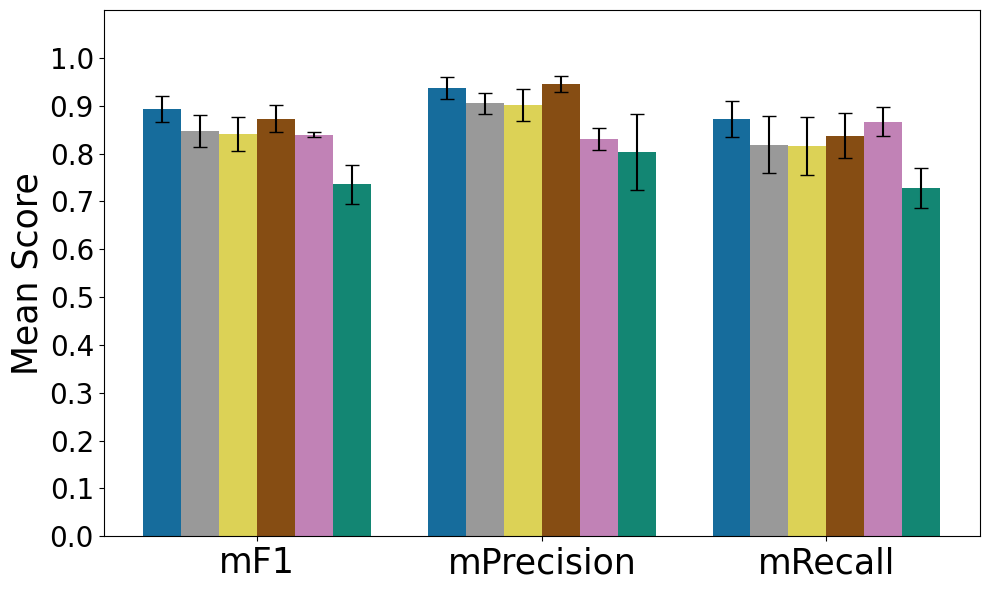

In [8]:
# Creating a DataFrame
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['savefig.transparent'] = True


# convert to numpy array
mf1_scores = np.array(mf1_scores)
mprecision_scores = np.array(mprecision_scores)
mrecall_scores = np.array(mrecall_scores)

data = {
    'Metric': ['mF1', 'mPrecision', 'mRecall'] * 6,
    'Mean Score': [
        np.array(pipeline_285_results[0]).mean(), np.array(pipeline_285_results[1]).mean(), np.array(pipeline_285_results[2]).mean(),
        np.array(results_np_classifier_fp[0]).mean(), np.array(results_np_classifier_fp[1]).mean(), np.array(results_np_classifier_fp[2]).mean(),
        np.array(pipeline_morgan_fp_results[0]).mean(), np.array(pipeline_morgan_fp_results[1]).mean(), np.array(pipeline_morgan_fp_results[2]).mean(),
        np.array(results_mhfp[0]).mean(), np.array(results_mhfp[1]).mean(), np.array(results_mhfp[2]).mean(),
        mf1_scores.mean(), mprecision_scores.mean(), mrecall_scores.mean(),
        np.array(results_neural_np_fp[0]).mean(), np.array(results_neural_np_fp[1]).mean(), np.array(results_neural_np_fp[2]).mean(),

    ],
    'STD': [
        np.array(pipeline_285_results[0]).std(), np.array(pipeline_285_results[1]).std(), np.array(pipeline_285_results[2]).std(),
        np.array(results_np_classifier_fp[0]).std(), np.array(results_np_classifier_fp[1]).std(), np.array(results_np_classifier_fp[2]).std(),
        np.array(pipeline_morgan_fp_results[0]).std(), np.array(pipeline_morgan_fp_results[1]).std(), np.array(pipeline_morgan_fp_results[2]).std(),
        np.array(results_mhfp[0]).std(), np.array(results_mhfp[1]).std(), np.array(results_mhfp[2]).std(),
        mf1_scores.std(), mprecision_scores.std(), mrecall_scores.std(),
        np.array(results_neural_np_fp[0]).std(), np.array(results_neural_np_fp[1]).std(), np.array(results_neural_np_fp[2]).std(),

    ],
    'Model':  ['Layered FP + Low Variance FS + Ridge Classifier'] * 3 + ['NP classifier FP'] * 3 + ['Morgan FP + Ridge Classifier'] * 3 + ['MHFP'] * 3 +
['MGCNN (Eguchi et al. 2019)'] * 3 + ['Neural NPFP'] * 3
    
}

df = pd.DataFrame(data)

# Plotting
# Plotting
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=df, x='Metric', y='Mean Score', hue='Model', palette=color_map)
legend = plt.legend(title='', bbox_to_anchor=(1.05, 1.15), loc='upper left', prop={'size': 25}, ncol=2)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
legend.remove()

# Iterate over the bars, adding error bars
for i, patch in enumerate(barplot.patches):
    # Get the x-coordinate of the bar's center
    if patch.get_height() != 0:
        x = patch.get_x() + patch.get_width() / 2
        # Get the corresponding standard deviation from the DataFrame
        std = df.loc[i % len(df), 'STD']  # Adjust index for std
        # Add error bar for this bar using plt.errorbar
        plt.errorbar(x, patch.get_height(), yerr=std, fmt='none', capsize=5, color='black')

        # barplot.annotate(format(patch.get_height(), '.3f'),  # Text to display
        #                 (patch.get_x() +patch.get_width() / 2., patch.get_height() + std/2 + 0.08),  # Position
        #                 ha='center', va='center',  # Center alignment
        #                 xytext=(0, 9),  # Distance from the top of the bar
        #                 textcoords='offset points',
        #                 rotation=90)  # Text rotation (90 degrees)

plt.title('', pad=20, size=25)
plt.ylabel('Mean Score', size=25)
plt.xlabel('')
#plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1.1)  # Extend y-axis limit
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size=20)
plt.xticks(size=25)
plt.tight_layout()
plt.savefig('cross_validation_metrics_eguchi_et_al_2019.png', dpi=400)

In [5]:
import pickle
from deepmol.loaders import CSVLoader

def generate_results_cv_for_statistics(pipeline, model_name):
    f1_score_results = []
    precision_score_results = []
    recall_score_results = []
    subject = []
    model_name_ = []
    for i in range(5):
        # read pickle file
        with open(f'./cv_data/dataset_trn_cv_{i}.pickle', 'rb') as f:
            train_cv_data = pickle.load(f)
        with open(f'./cv_data/dataset_tst_cv_{i}.pickle', 'rb') as f:
            test_cv_data = pickle.load(f)

        field_task15 = ['Anthranilate',
                    'Cholesterol',
                    'GGPP',
                    'Indole.3',
                    'IPP',
                    'L.Ala',
                    'L.Arg',
                    'L.Asp',
                    'L.His',
                    'L.Lys',
                    'L.Phe',
                    'L.Pro',
                    'L.Trp',
                    'L.Tyr',
                    'Secologanin']
        data_path = "cv_data/alkaloid_data.csv"
        dataset = CSVLoader(data_path, smiles_field='SMILES', labels_fields=field_task15, id_field='CID').create_dataset()
        train_cv_data = dataset.select(train_cv_data, inplace=False)
        test_cv_data = dataset.select(test_cv_data, inplace=False)

        #fit the pipeline
        pipeline.fit(train_cv_data)
        test_cv_data = pipeline.transform(test_cv_data)
        from sklearn.metrics import f1_score, precision_score, recall_score
        from deepmol.metrics import Metric


        predictions = pipeline.predict(test_cv_data)
        y_true = test_cv_data.y
        y_pred = predictions
        for task in range(y_true.shape[1]):
            f1_score_results.append(f1_score(y_true[:, task], y_pred[:, task]))
            precision_score_results.append(precision_score(y_true[:, task], y_pred[:, task]))
            recall_score_results.append(recall_score(y_true[:, task], y_pred[:, task]))
            subject.append(f'cv_{i}_task_{task}')
            model_name_.append(model_name)
    

    return pd.DataFrame({"model name": model_name,'f1_score': f1_score_results, 'precision_score': precision_score_results, 'recall_score': recall_score_results, 'subject': subject})

In [ ]:
pipeline_names = ["Layered FP + Ridge Classifier", "NPClassifierFP + Ridge Classifier", "MHFP + Ridge Classifier", "Morgan FP + Ridge Classifier", "Neural NPFP + MLPs (Classifier Chain)"]

import pandas as pd
results = pd.DataFrame()
for pipeline, name in zip([pipeline_285, pipeline_mhfp, pipeline_np_classifier, pipeline_morgan_fp, pipeline_neural_npfp], pipeline_names):
    print(name)
    results_ = generate_results_cv_for_statistics(pipeline, name)
    results = pd.concat([results, results_], axis=0)

In [8]:
import os

import numpy as np
import re

mgcnn_results = os.listdir('./mgcnn_results/')

f1_scores = []
precision_scores = []
recall_scores = []
subject = []
for result in mgcnn_results:
    if "f1_score" in result:
        number = re.findall(r'\d+', result)[1]
    else:
        number = re.search(r'\d+', result).group()
    if "f1_score" in result:
        with open(f'./mgcnn_results/{result}', 'r') as f:
            mgcnn_f1_scores = f.readlines()
            # identify the number in path with a regex
                
            for i in range(len(mgcnn_f1_scores)):
                f1_scores.append(float(mgcnn_f1_scores[i].strip()))
                subject.append(f'cv_{number}_task_{i}')

    elif "precision" in result:
        with open(f'./mgcnn_results/{result}', 'r') as f:
            mgcnn_precision_scores = f.readlines()
            for i in range(len(mgcnn_precision_scores)):
                precision_scores.append(float(mgcnn_precision_scores[i].strip()))

    elif "recall" in result:
        with open(f'./mgcnn_results/{result}', 'r') as f:
            mgcnn_recall_scores = f.readlines()
            for i in range(len(mgcnn_recall_scores)):
                recall_scores.append(float(mgcnn_recall_scores[i].strip()))

results = pd.concat([results, pd.DataFrame({"model name": ["MGCNN (Eguchi et al. 2019)"]*len(f1_scores),'f1_score': f1_scores, 'precision_score': precision_scores, 'recall_score': recall_scores, 'subject': subject})], axis=0)

In [9]:
results.to_csv("results_by_label_and_fold.csv", index=False)

In [11]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['model name'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['model name'] == pipeline1)]['f1_score']
    f1_scores2 = results[(results['model name'] == pipeline2)]['f1_score']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(f1_scores1, f1_scores2)
        if p_value < 0.05:
            significant_differences_f1.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_f1:
    
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


Significant difference between Layered FP + Ridge Classifier and NPClassifierFP + Ridge Classifier with p-value 0.03257156587619967
Significant difference between Layered FP + Ridge Classifier and MHFP + Ridge Classifier with p-value 5.288480924760645e-05
Significant difference between Layered FP + Ridge Classifier and Morgan FP + Ridge Classifier with p-value 5.219185010859611e-06
Significant difference between Layered FP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 3.071950888633399e-10
Significant difference between Layered FP + Ridge Classifier and MGCNN (Eguchi et al. 2019) with p-value 0.00026126929805578926
Significant difference between NPClassifierFP + Ridge Classifier and MHFP + Ridge Classifier with p-value 0.01065225709588107
Significant difference between NPClassifierFP + Ridge Classifier and Morgan FP + Ridge Classifier with p-value 0.004217214199334807
Significant difference between NPClassifierFP + Ridge Classifier and Neural NPFP + MLPs (Cl

In [12]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['model name'].unique()
significant_differences_recall = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    recall_scores1 = results[(results['model name'] == pipeline1)]['recall_score']
    recall_scores2 = results[(results['model name'] == pipeline2)]['recall_score']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(recall_scores2):
        stat, p_value = stats.wilcoxon(recall_scores1, recall_scores2)
        if p_value < 0.05:
            significant_differences_recall.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_recall:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


Significant difference between Layered FP + Ridge Classifier and NPClassifierFP + Ridge Classifier with p-value 0.004478183997623294
Significant difference between Layered FP + Ridge Classifier and MHFP + Ridge Classifier with p-value 0.00040204025597243215
Significant difference between Layered FP + Ridge Classifier and Morgan FP + Ridge Classifier with p-value 0.0001928054843414454
Significant difference between Layered FP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 4.03539341435299e-08
Significant difference between NPClassifierFP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 8.145359498527132e-07
Significant difference between MHFP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 3.270840597890063e-05
Significant difference between MHFP + Ridge Classifier and MGCNN (Eguchi et al. 2019) with p-value 0.004709927159559633
Significant difference between Morgan FP + Ridge Classifier and Neural NPFP + MLPs

In [13]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['model name'].unique()
significant_differences_precision = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    precision_scores1 = results[(results['model name'] == pipeline1)]['precision_score']
    precision_scores2 = results[(results['model name'] == pipeline2)]['precision_score']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(precision_scores1, precision_scores2)
        if p_value < 0.05:
            significant_differences_precision.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_precision:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


Significant difference between Layered FP + Ridge Classifier and MHFP + Ridge Classifier with p-value 0.003855038955145906
Significant difference between Layered FP + Ridge Classifier and Morgan FP + Ridge Classifier with p-value 0.013495240558764138
Significant difference between Layered FP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 5.166482125859142e-07
Significant difference between Layered FP + Ridge Classifier and MGCNN (Eguchi et al. 2019) with p-value 1.9802517299013524e-07
Significant difference between NPClassifierFP + Ridge Classifier and MHFP + Ridge Classifier with p-value 0.00036714006887108766
Significant difference between NPClassifierFP + Ridge Classifier and Morgan FP + Ridge Classifier with p-value 0.0009363810386866664
Significant difference between NPClassifierFP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 1.584381811220643e-07
Significant difference between NPClassifierFP + Ridge Classifier and MGCNN (Egu

In [14]:
for diff in significant_differences_precision:
    print(f"{diff[0]} vs {diff[1]}: {diff[2]}")

Layered FP + Ridge Classifier vs MHFP + Ridge Classifier: 0.003855038955145906
Layered FP + Ridge Classifier vs Morgan FP + Ridge Classifier: 0.013495240558764138
Layered FP + Ridge Classifier vs Neural NPFP + MLPs (Classifier Chain): 5.166482125859142e-07
Layered FP + Ridge Classifier vs MGCNN (Eguchi et al. 2019): 1.9802517299013524e-07
NPClassifierFP + Ridge Classifier vs MHFP + Ridge Classifier: 0.00036714006887108766
NPClassifierFP + Ridge Classifier vs Morgan FP + Ridge Classifier: 0.0009363810386866664
NPClassifierFP + Ridge Classifier vs Neural NPFP + MLPs (Classifier Chain): 1.584381811220643e-07
NPClassifierFP + Ridge Classifier vs MGCNN (Eguchi et al. 2019): 3.157847255652853e-07
MHFP + Ridge Classifier vs Neural NPFP + MLPs (Classifier Chain): 1.8433617151213364e-05
MHFP + Ridge Classifier vs MGCNN (Eguchi et al. 2019): 0.0005196521317482277
Morgan FP + Ridge Classifier vs Neural NPFP + MLPs (Classifier Chain): 2.721633261065293e-05
Morgan FP + Ridge Classifier vs MGCNN (Eg

In [15]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [16]:
# generate a table with significant differences
significant_differences = significant_differences_f1
# transform p-values to asterisks
significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, pvalue in significant_differences]

significant_differences_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (F1 score)"])

In [17]:
import pandas as pd

def generate_plain_latex_table(df):
    # Start LaTeX table
    latex_table = "\\begin{table}[htbp]\n\\centering\n\\begin{tabular}{|" + "c|" * len(df.columns) + "}\n\\hline\n"
    
    # Add column headers
    headers = ' & '.join(df.columns) + " \\\\\n\\hline\n"
    latex_table += headers

    # Add rows with values from the DataFrame
    for index, row in df.iterrows():
        row_data = ' & '.join(map(str, row)) + " \\\\\n\\hline\n"
        latex_table += row_data
    
    # End LaTeX table
    latex_table += "\\end{tabular}\n\\caption{Significant Differences Table}\n\\end{table}"

    return latex_table

latex_code = generate_plain_latex_table(significant_differences_df)
print(latex_code)


\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|}
\hline
Pipeline 1 & Pipeline 2 & Differences (F1 score) \\
\hline
Layered FP + Ridge Classifier & NPClassifierFP + Ridge Classifier & * \\
\hline
Layered FP + Ridge Classifier & MHFP + Ridge Classifier & **** \\
\hline
Layered FP + Ridge Classifier & Morgan FP + Ridge Classifier & **** \\
\hline
Layered FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & **** \\
\hline
Layered FP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & *** \\
\hline
NPClassifierFP + Ridge Classifier & MHFP + Ridge Classifier & * \\
\hline
NPClassifierFP + Ridge Classifier & Morgan FP + Ridge Classifier & ** \\
\hline
NPClassifierFP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & **** \\
\hline
NPClassifierFP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & ** \\
\hline
MHFP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & **** \\
\hline
Morgan FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & **** \\
\h

In [18]:
# generate a table with significant differences
significant_differences = significant_differences_precision
# transform p-values to asterisks
significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, pvalue in significant_differences]

significant_differences_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (Precision score)"])

latex_code = generate_plain_latex_table(significant_differences_df)
print(latex_code)


\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|}
\hline
Pipeline 1 & Pipeline 2 & Differences (Precision score) \\
\hline
Layered FP + Ridge Classifier & MHFP + Ridge Classifier & ** \\
\hline
Layered FP + Ridge Classifier & Morgan FP + Ridge Classifier & * \\
\hline
Layered FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & **** \\
\hline
Layered FP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & **** \\
\hline
NPClassifierFP + Ridge Classifier & MHFP + Ridge Classifier & *** \\
\hline
NPClassifierFP + Ridge Classifier & Morgan FP + Ridge Classifier & *** \\
\hline
NPClassifierFP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & **** \\
\hline
NPClassifierFP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & **** \\
\hline
MHFP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & **** \\
\hline
MHFP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & *** \\
\hline
Morgan FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & **** \\
\hlin

In [20]:
# generate a table with significant differences
significant_differences = significant_differences_recall
# transform p-values to asterisks
significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, pvalue in significant_differences]

significant_differences_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (Recall score)"])

latex_code = generate_plain_latex_table(significant_differences_df)
print(latex_code)


\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|}
\hline
Pipeline 1 & Pipeline 2 & Differences (Recall score) \\
\hline
Layered FP + Ridge Classifier & NPClassifierFP + Ridge Classifier & ** \\
\hline
Layered FP + Ridge Classifier & MHFP + Ridge Classifier & *** \\
\hline
Layered FP + Ridge Classifier & Morgan FP + Ridge Classifier & *** \\
\hline
Layered FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & **** \\
\hline
NPClassifierFP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & **** \\
\hline
MHFP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & **** \\
\hline
MHFP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & ** \\
\hline
Morgan FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & **** \\
\hline
Morgan FP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & ** \\
\hline
Neural NPFP + MLPs (Classifier Chain) & MGCNN (Eguchi et al. 2019) & **** \\
\hline
\end{tabular}
\caption{Significant Differences Table}
\end{table}
